**Порядковый номер в списке группы - 5. Вариант датасета - 20**

https://www.kaggle.com/fmejia21/trump-impeachment-polls

**Задание**
Для заданного набора данных постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения модели используйте ансамблевые модели: случайный лес и градиентный бустинг. Оцените качество модели на основе подходящих метрик качества (не менее трех метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей?

# Первичная обработка данных



In [0]:
# Импорт библотек
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score

In [433]:
data1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ММО/РК2/impeachment-polls.csv')
data1.shape

(542, 24)

In [434]:
data1.columns

Index(['Start', 'End', 'Pollster', 'Sponsor', 'SampleSize', 'Pop', 'tracking',
       'Text', 'Category', 'Include?', 'Yes', 'No', 'Unsure', 'Rep Sample',
       'Rep Yes', 'Rep No', 'Dem Sample', 'Dem Yes', 'Dem No', 'Ind Sample',
       'Ind Yes', 'Ind No', 'URL', 'Notes'],
      dtype='object')

Выбранный набор данных содержит результаты опросов на тему эмпичмента президента США Дональда Трампа. Часть колонок несет описательный характер и бесполезна для решения задачи регрессии (напрмер: Текст выступления, ссылка на первоисточник, спонсоры тестирования и т.д.). Имеет смысл отказаться от этих колонок.



In [435]:
data1 = data1[data1.columns[8:22]]
data1 = data1.drop(['Rep Sample', 'Dem Sample', 'Ind Sample'], axis=1)
data1.head()

,Category,Include?,Yes,No,Unsure,Rep Yes,Rep No,Dem Yes,Dem No,Ind Yes,Ind No
0,begin_proceedings,yes,37.0,59.0,4.0,7.0,87.0,61.0,36.0,37.0,59.0
1,begin_proceedings,yes,37.0,56.0,6.0,10.0,87.0,62.0,29.0,36.0,59.0
2,begin_proceedings,yes,40.0,55.0,6.0,7.0,90.0,64.0,30.0,42.0,53.0
3,begin_proceedings,yes,49.0,46.0,5.0,15.0,82.0,75.0,21.0,49.0,46.0
4,begin_inquiry,yes,43.0,51.0,5.0,5.0,93.0,77.0,15.0,41.0,53.0


Таким образом, после отсечения малоинформативных колонок, остались следующие:
* Категория допроса
* Использование вопросов в голосовании
* Процент проголосовавших за
* Процент проголосовавших против
* Процент воздержавшихся от голосования
* Проценты проголосовавших по партиям (Республиканская, Демократическая и Независимая)


Рассмотрим категории голосования:



In [436]:
for a in data1['Category'].unique():
  print(a)

begin_proceedings
begin_inquiry
impeach_and_remove
reasons
impeach
consider
if_impeach_then_remove
remove
nan


Каждая категория голосования соответствует различным видам судебных разбирательств:

* begin proceedings  - начать судебное разбирательство
* begin inquiry - начать расследование
* impeach and remove - привлечь к ответственности и удалить с поста
* reasons  - причины
* impeach - импичмент
* consider - рассмотреть
* if impeach then remove - если импичмент, то удалить
* remove - Удалить

In [437]:
data1.isnull().sum()

Category      1
Include?      0
Yes           0
No            0
Unsure       21
Rep Yes      33
Rep No       50
Dem Yes      27
Dem No       51
Ind Yes      95
Ind No      112
dtype: int64

Проверка на пропуски показала, что в тех голосованиях, где члены партий  не голосвали или имели нулевое количество проголосовавших, в таблице стоит пропуск. Пропуски такого рода стоит заменить на 0.

В перменной Category наблюдается всего один пропуск. Имеет смысл удалить наблюдение с этим пропуском.

In [0]:
isNullCategory = data1[data1['Category'].isnull() == True].index
data2 = data1.drop(isNullCategory)

Также, для более продуктивного дальнейшего анализа необходимо выполнить кодирование категориальных параметров в числовой формат

In [439]:
data2 = data2.fillna(0)
LE = LabelEncoder()
include = LE.fit_transform(data2['Include?'])
data2['Include?'] = include 
data2.head(3)

,Category,Include?,Yes,No,Unsure,Rep Yes,Rep No,Dem Yes,Dem No,Ind Yes,Ind No
0,begin_proceedings,1,37.0,59.0,4.0,7.0,87.0,61.0,36.0,37.0,59.0
1,begin_proceedings,1,37.0,56.0,6.0,10.0,87.0,62.0,29.0,36.0,59.0
2,begin_proceedings,1,40.0,55.0,6.0,7.0,90.0,64.0,30.0,42.0,53.0


# Разведочный анализ данных

После первичной обработки данных, наибольший интерес представляет корреляционный анализ.

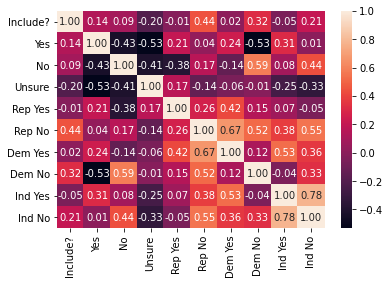

In [440]:
sns.heatmap(data2.corr(), annot=True, fmt='.2f')

А также необходимо построить парные диаграммы для ознакомления с распределением переменных.


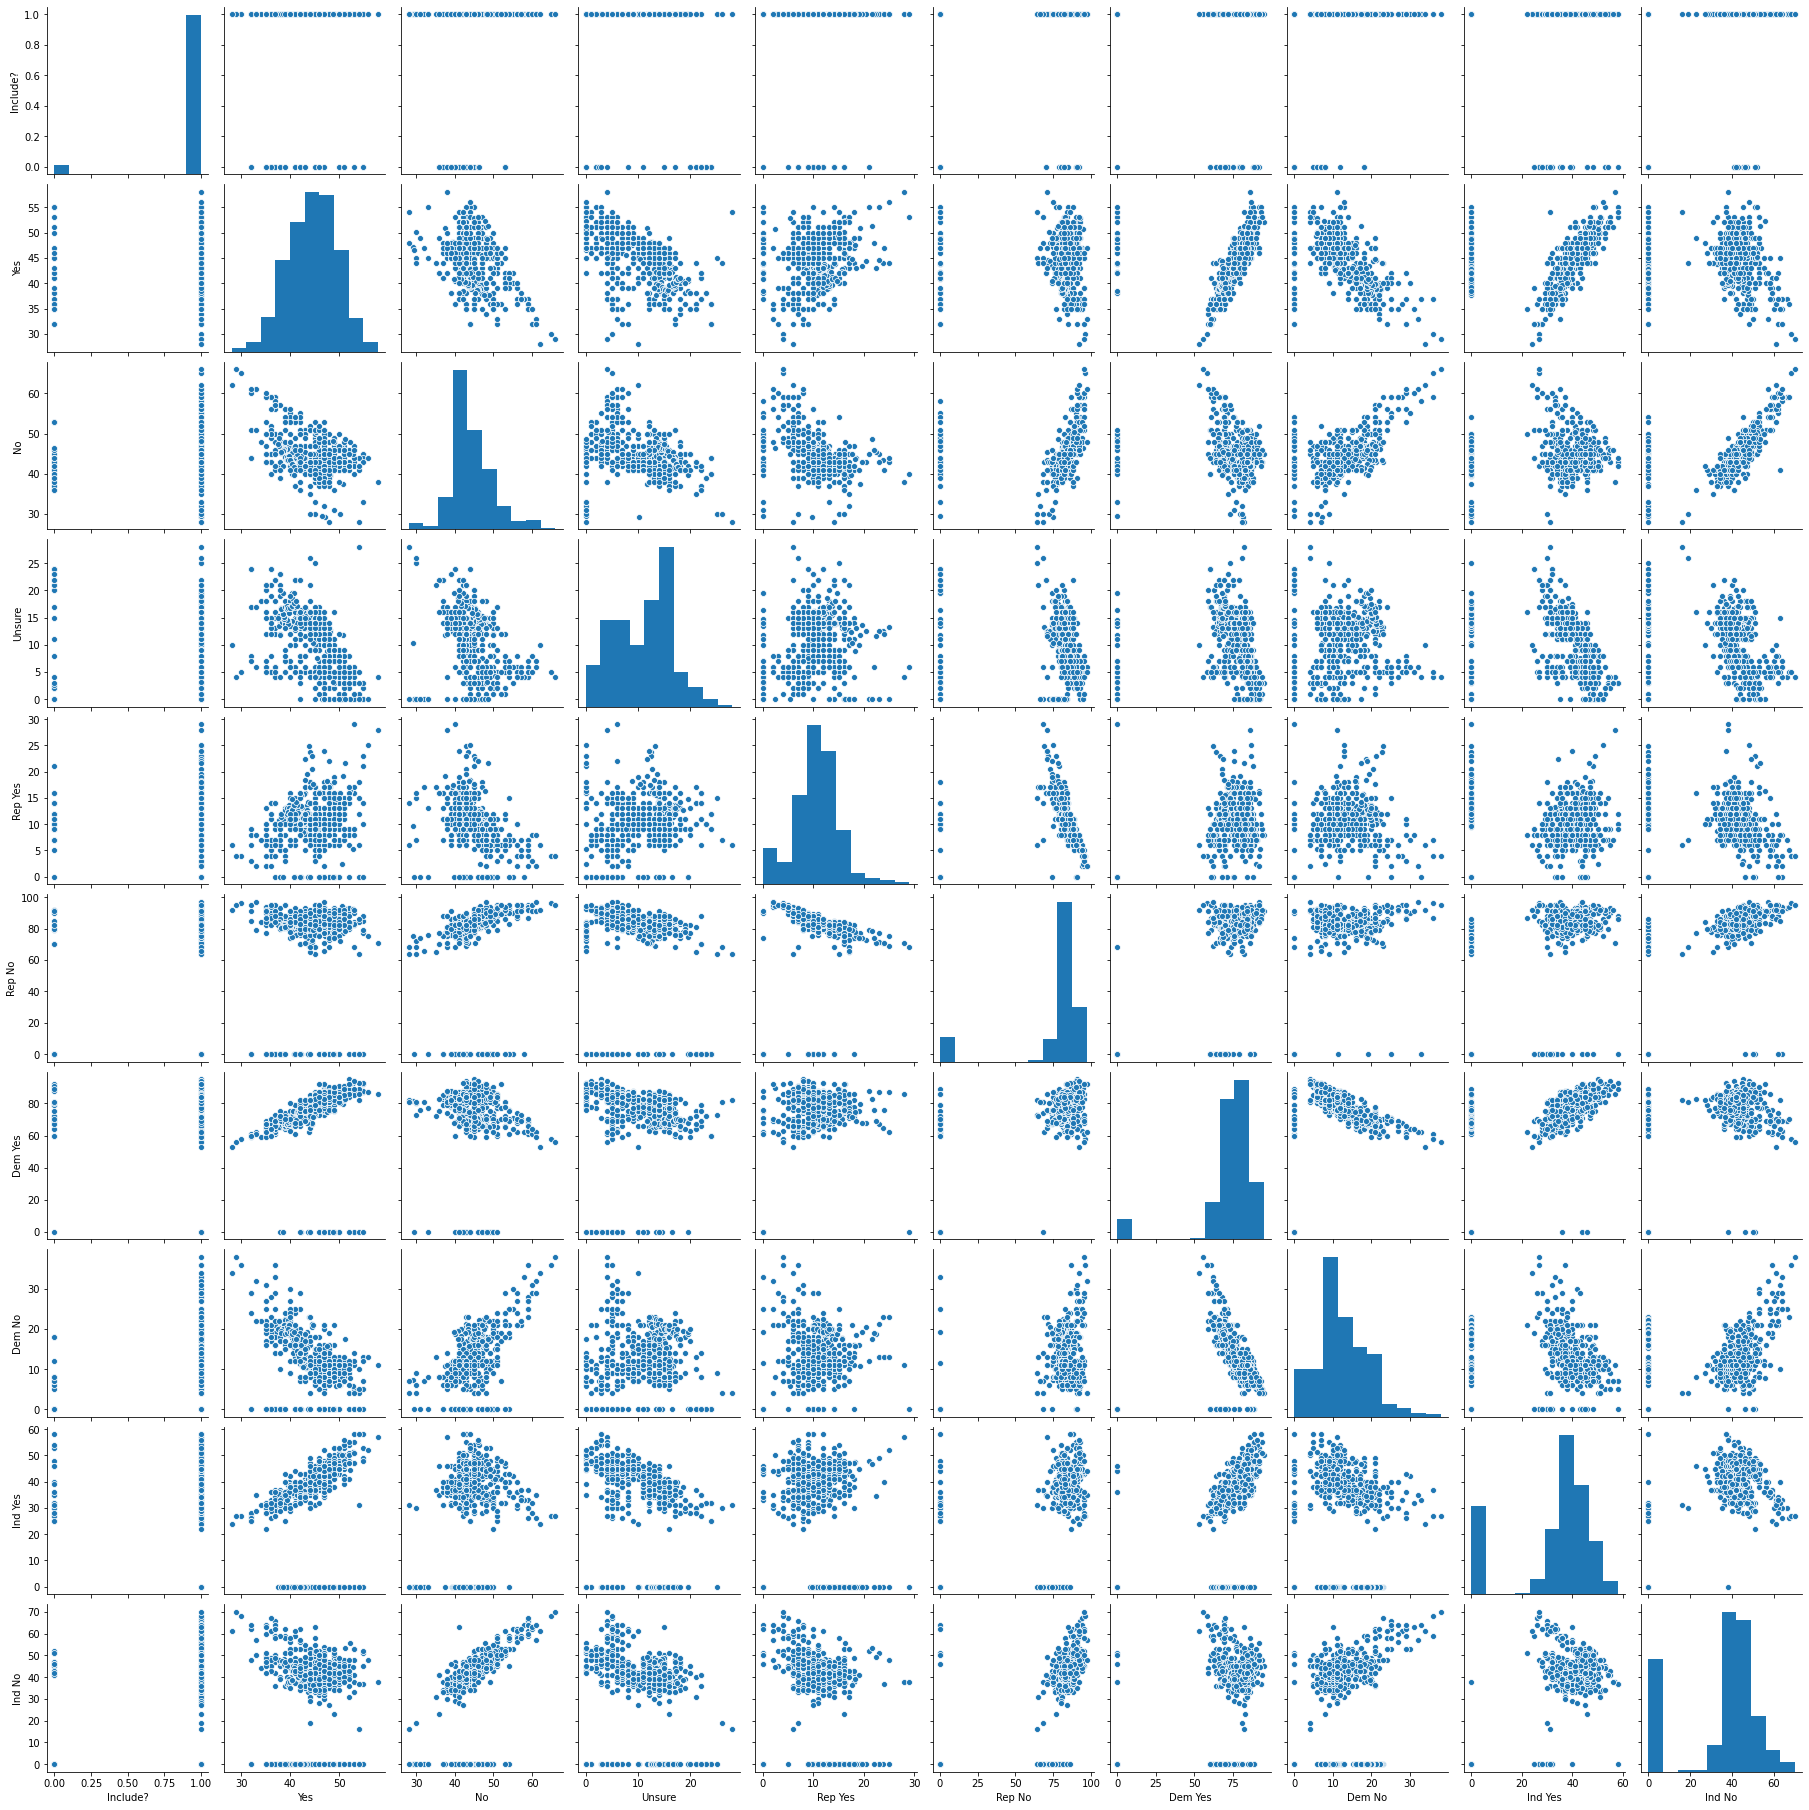

In [441]:
# Парные диаграммы
sns.pairplot(data2)

Исходя из результатов корреляционного анализа и парных диаграмм, можно придти к следующему: ввиду того, что на результаты голосвания влияют голоса трех партий, имеет смысл рассмотреть влияние каждой партии на результат детально.

In [442]:
# Колонки с голосами ЗА
YesVotes = ['Rep Yes', 'Dem Yes', 'Ind Yes']
# Колонки с голосами ПРОТИВ
NoVotes = ['Rep No', 'Dem No', 'Ind No']

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=3, start_cell="top-left")

for i in range(len(YesVotes)):
  fig.add_trace(go.Scatter(x=data2['Yes'], y=data2[YesVotes[i]], mode='markers', name=YesVotes[i]),
              row=1, col=i+1)
  fig.add_trace(go.Scatter(x=data2['No'], y=data2[NoVotes[i]], mode='markers', name=NoVotes[i]),
              row=2, col=i+1)
fig.show()

Анализируя графики, изображенные выше, можно придти к следующим выводам:
1. Голоса "ЗА" членов республиканской партии имеют самое слабое влияние на общее число голосующих "ЗА". Голоса "ПРОТИВ" республиканцев имеют смещенное вверх распредление на диаграмме зависимости от общего числа голосовавших "ПРОТИВ". **Вывод**: Представители республиканской партии неохотно голосуют "ЗА" (не больше 30%) и активно голосуют "ПРОТИВ" в различных голосованиях, связанных в той, или иной степени с импичментом Дональда Трампа. *Примечание:* Дональд Трамп является выдвиженцем от республиканской партии.


2. В случае демократической партии, можно сказать обратное: голоса "ПРОТИВ" имеют разреженный характер (число голосов "ПРОТИВ" не превышает планку в 40%), тогда как голоса "ЗА" высоко распределены на фоне общего числа голосов "ЗА". **Вывод**: Демократическая партия активнее остальных голосует "ЗА" импичмент президента. В случае голосов "ЗА", члены демократической партии воздерживаются от голоса реже остальных случаев. 

3. Голоса "ЗА" и "ПРОТИВ" независимых партий имеют одинакове распрделение. По сравнению с голосами остальных партий, члены независимой партии воздерживаются от голосования чаще остальных. **Вывод**: Члены независимой партии США имеют непредвзятое мнение, по сравнению с результатами голосования ругих партий. 

**Общий вывод:**Исходя из вышесказанного, можно придти к пониманию нетривиальности ситуации: тогда как большая часть республиканцев отстаивает идею против импичмента, демократическию партии отстаивают идею отставки президента.Члены независимой партии имеют наиболее непредвзятое мнение, однако, в большинстве случаев воздерживаются от голосования.


Далее рассмотрим категории голосования.

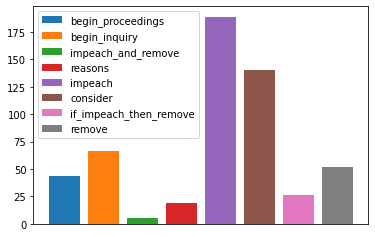

In [443]:
categories = data2['Category'].unique()
NewCategories = LE.fit_transform(data2['Category'])
data2['Category'] = NewCategories

ax0 = plt.subplot()
for ind in range(len(categories)):
  newClass = data2[data2['Category'] == ind].shape[0]
  ax0.bar( str(categories[ind]), newClass, label=str(categories[ind]))

ax0.legend()
ax0.get_xaxis().set_ticks([])
plt.show()

**Вывод:** Таким образом, большая часть голосований проводится по категории "Импичмент" и "Принятие во внимание". 

#  Обучение моделей

Подготовка моделей для решения слудющей задачи: **Предсказание числа проголосовавших "ЗА" импичмент среди членов независимой партии**.

Данная задача относится к регрессии.

Выбор метрик качества моделей регрессии:

1. Mean squared error - средняя квадратичная ошибка
2. Mean absolute error - средняя абсолютная ошибка
3. Метрика R2 или коэффициент детерминации

Данный набор метрик позволяет наиболее точно оценить качество построенных моделей.

In [0]:
# Метод оценки качества модели регрессии
def regressionMetrics(y_test, y_predicted):
  print('MSE: \t', mean_squared_error(y_test, y_predicted))
  print('MAE: \t', mean_absolute_error(y_test, y_predicted))
  print('R2: \t', r2_score(y_true=np.array(y_test), y_pred=y_predicted ))

Разделение на тестовую и валидационную выборку.

In [0]:
impeachment = data2[data2['Category'] == 4]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(impeachment[['Rep Yes', 'Dem Yes']], \
                                                   impeachment['Ind Yes'], \
                                                   test_size=0.6, \
                                                   random_state=15)

**Случайный лес (регрессия)**

In [465]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
tree1 = RandomForestRegressor(n_estimators=3, criterion='mse', random_state=4, max_depth=3, max_features=0.2, min_samples_leaf=0.04)
tree1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features=0.2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.04,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=3, n_jobs=None, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)

**AdaBoost**

In [0]:
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, max_features=1)

In [469]:
from sklearn.ensemble import AdaBoostRegressor
ab1 = AdaBoostRegressor( base_estimator=DTR, n_estimators=5, loss='square' )
ab1.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=3,
                                                       max_features=1,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  lea

# Оценка качества полученных моделей

Метрики качества для AdaBoost

In [470]:
ab1Prediction = ab1.predict(X_test)
regressionMetrics(y_test, ab1Prediction)

MSE: 	 243.96286564763867
MAE: 	 12.673394699115649
R2: 	 0.22546595927237034


Метрики качества для Смешанного леса

In [471]:
tree1Prediction = tree1.predict(X_test)
regressionMetrics(y_test, tree1Prediction)

MSE: 	 246.84058491409098
MAE: 	 11.667978165032716
R2: 	 0.21632976747691768


**Выводы**: Результаты оставляют желать лучшего - построенные модели обладают крайне низким коэффициентом детерминизации и высокими СКО. Выбросы, в виде отсутсвия голоса, могли сильно исказить результаты, ввиду того, что в основе Смешанного леса и AdaBoost лежат деревья. Однако отказ от наблюдений с воздержавшимися от права голоса членами партий, может существенно урезать входной набор данных. Для решения поставленной задачи имеет смысл попробовать применить иные модели машинного обучения, такие как: 

* KNNRegressor
* Линейная регрессия
* SVR (после масштабирования данных) 